<a href="https://colab.research.google.com/github/jmaydwell1/Tensorflow-Deep-Learning/blob/main/04_transfer_learning_in_tensoflow_part1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part 1: Feature Extraction

Transfer learning is leveragin a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
  1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
  2. Can leverage a working nerual network architecture which has already learned patternns on similar data to our own, then we can adapt those patterns to our own data

In [1]:
# Are we using a GPU?
!nvidia-smi


Tue Aug 23 13:03:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# Get dataa (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-08-23 13:03:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 142.251.45.112, 172.217.164.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   194MB/s    in 0.8s    

2022-08-23 13:03:43 (194 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"Ther are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

Ther are 2 directories and 0 images in '10_food_classes_10_percent'. 
Ther are 10 directories and 0 images in '10_food_classes_10_percent/test'. 
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'. 
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'. 
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'. 
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'. 
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'. 
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'. 
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'. 
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'. 
Ther are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'. 
Ther are 0 directories and 250 images in '10_food_classes_10_percent/

## Creatign data loaders (preparing the data)
We'll use the `ImageDataGenerator` class to load in our images in batches

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be preformed during or after training. Some of the most popular callbacks:
  * Tracking experiments with the TensorBoard callback
  * Model checkpoint with the ModelCheckpoint callback
  * Stoppoing a model from training (before it trains too long and overfits) with the EarlyStopping callback 

In [5]:
# Create TensorBoard callback (functionized because we need to crate a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback =  tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to crate our own models layer by layer from scratch.
Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow hub.
We can acces pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found th efollowing feature vector model link:

In [6]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# let's maek a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """ 
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
  model_url (str): A TensorFlow Hub feature extraction URL.
  num_classes (int): Number of output neurons in the output layers,
    should be equal to number of target classes, defualt 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layers
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220823-130402
Epoch 1/5
24/24 [==============================] - 32s 741ms/step - loss: 1.9203 - accuracy: 0.3427 - val_loss: 1.2168 - val_accuracy: 0.6260
Epoch 2/5
24/24 [==============================] - 16s 699ms/step - loss: 0.9056 - accuracy: 0.7427 - val_loss: 0.8610 - val_accuracy: 0.7332
Epoch 3/5
24/24 [==============================] - 15s 662ms/step - loss: 0.6244 - accuracy: 0.8307 - val_loss: 0.7530 - val_accuracy: 0.7548
Epoch 4/5
24/24 [==============================] - 15s 661ms/step - loss: 0.4785 - accuracy: 0.8813 - val_loss: 0.7117 - val_accuracy: 0.7744
Epoch 5/5
24/24 [==============================] - 15s 661ms/step - loss: 0.3799 - accuracy: 0.9147 - val_loss: 0.6689 - val_accuracy: 0.7820


Wow!

That. Is. Incredible. Our transfer learnng feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [12]:
# Let's create a function plot our loss curves...
# Tidbit: you could put a function like this into a script callded "helper.py" and import 
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of trianing/validation loss and accuracy metrics.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plots loss
  plt.plot(epochs, loss, label="training_loss") 
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


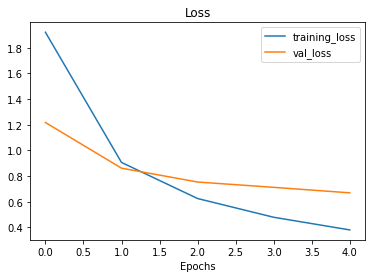

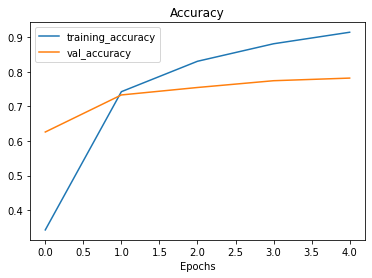

In [13]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 Tensorflow Hub Featur Extraction model

In [14]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])


Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220823-130547
Epoch 1/5
24/24 [==============================] - 34s 1s/step - loss: 1.8199 - accuracy: 0.4347 - val_loss: 1.2640 - val_accuracy: 0.7536
Epoch 2/5
24/24 [==============================] - 15s 634ms/step - loss: 1.0378 - accuracy: 0.7867 - val_loss: 0.8568 - val_accuracy: 0.8256
Epoch 3/5
24/24 [==============================] - 15s 639ms/step - loss: 0.7450 - accuracy: 0.8453 - val_loss: 0.6907 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 15s 638ms/step - loss: 0.5994 - accuracy: 0.8707 - val_loss: 0.6053 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 15s 640ms/step - loss: 0.5066 - accuracy: 0.8893 - val_loss: 0.5519 - val_accuracy: 0.8648


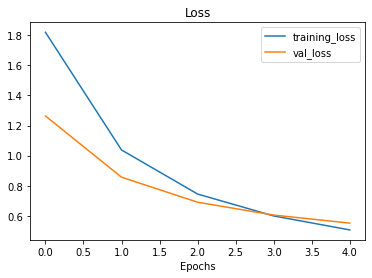

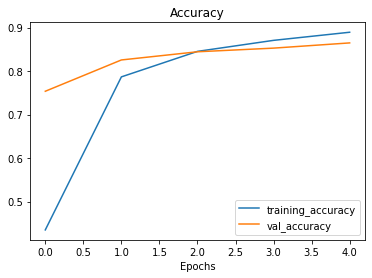

In [15]:
plot_loss_curves(efficientnet_history)

In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [19]:
resnet_model.summary(
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [21]:
# How many layers doe our effecientnetb0 feature extractor have/
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

  * **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. usin ImageNet model on 1000 ImageNet classes, none of your own)
  * **"Featrue extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> classes of food)
  * **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

**Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do notupload them to TensorBoard.dev

In [22]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the trainig data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=wNj7YhwZq4mlOyISON0nFtYPvPythy&prompt=consent&access_type=off

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/AoVA8xBOQEuDoFg17RK2ww/

In [23]:
# Check out what TensorBoard experiments you have
!tensorboard dev list 

https://tensorboard.dev/experiment/AoVA8xBOQEuDoFg17RK2ww/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the trainig data
	Id                   AoVA8xBOQEuDoFg17RK2ww
	Created              2022-08-23 13:31:22 (3 minutes ago)
	Updated              2022-08-23 13:31:24 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918538
Total: 1 experiment(s)


In [24]:
# Delete an experiment
!tensorboard dev delete --experiment_id 

usage: tensorboard dev delete [-h] [--helpfull]
                              [--experiment_id EXPERIMENT_ID]
tensorboard dev delete: error: argument --experiment_id: expected one argument


In [1]:
# Confrim the deletion by re-checking what experiments your have left
!tensor dev list

/bin/bash: tensor: command not found
